# TME 4 Module
Ici nous allons etudier les features Sequentiel, Module et Optimiser de PyTorch.
On commence en implementant l'architecture classique :

Lineaire --> Relu --> Lineaire --> Logistic -> CrossEntropy

In [55]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys

from load_data import get_train_test_loaders
from tools import get_minibatches

from torch.nn.modules.loss import CrossEntropyLoss
from torch.nn import Tanh, Sigmoid, Linear
from ReluFunction import Relu
from torch.nn.modules import Sequential
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss, CrossEntropyLoss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_loader, val_loader, test_loader, train_size, val_size, test_size = get_train_test_loaders(binary=False)
torch.cuda.set_device(0)
device = torch.device('cuda')
dtype = torch.float

In [14]:
class EarlyStop:
    
    def __init__(self, min_delta=0, patience=2):
        self.patience = patience
        self.best_loss = 1e-15
        self.min_delta = min_delta
        self.wait = 0
        
    def continue_still(self, current_loss):
        if (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 1
        else:
            if self.wait >= self.patience:
                return False # don't continue anymore
            self.wait += 1
        return True# continue still

In [58]:
def n_layer_nn(optimiser_function, layer_dims=[28*28 + 1, 128, 10], learning_rate=0.1, epochs=100):
    layers = len(layer_dims)
    assert layers >= 3, "Please give at leaset 3 dimensions"
    
    modules = [Linear(layer_dims[0], layer_dims[1]), Relu()]
    for i in range(1, layers - 2):
        modules.append(Linear(layer_dims[i], layer_dims[i+1]))
        modules.append(Relu())
    
    modules.append(Linear(layer_dims[layers-2], layer_dims[layers-1]))
    modules.append(Sigmoid())
    print(modules)
    model = Sequential(*modules).cuda('cuda:0')

    loss_function = CrossEntropyLoss()

    optimiser = optimiser_function(model.parameters(), lr=learning_rate)

    stopper = EarlyStop(patience=3)
    train_losses=[]
    val_losses=[]
    accuracy=[]

    for epoch in range(epochs):
        losses=[]
        for i,(X, y) in enumerate(get_minibatches(train_loader, device)):
            optimiser.zero_grad()
            yhat = model.forward(X)
            loss = loss_function(yhat, y.argmax(1))
            losses.append(loss.item())
            loss.backward()
            optimiser.step()

        train_losses.append(np.mean(losses))

        if epoch % 3 == 0:
            with torch.no_grad():
                losses = []
                corrects = 0
                for i,(X, y) in enumerate(get_minibatches(val_loader, device)):
                    y = y.argmax(1)
                    yhat = model.forward(X)
                    losses.append(loss_function(yhat, y).item())
                    ypred = yhat.argmax(1)
                    corrects += (ypred == y).sum()
                val_loss = np.mean(losses)
                val_losses.append(val_loss)
                acc = corrects.cpu().numpy() / val_size
                #print("Accuracy {}".format(acc))
                accuracy.append(acc)
                if not stopper.continue_still(val_loss):
                    print("Early stop at epoch {}".format(epoch))
                    break
    return val_losses, accuracy

In [36]:
train_loss=np.array(train_loss)
val_loss=np.array(val_loss)
accuracy=np.array(accuracy)

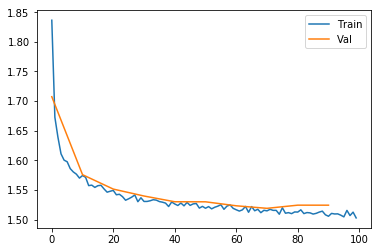

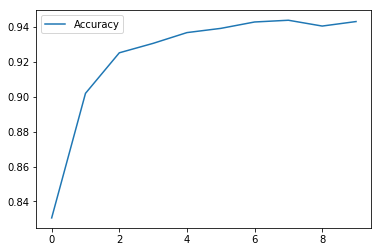

In [37]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="Train")
plt.plot(val_loss[:,0], val_loss[:,1], label="Val")
plt.legend()

plt.figure()
plt.plot(range(len(accuracy)), accuracy, label="Accuracy")
plt.legend()

### HighWay
https://arxiv.org/pdf/1507.06228.pdf
High Way est une module non-linéaire, qui permet d'apprendre les reseax trés profondes.

In [12]:
from torch.nn import ModuleList, Module

class Highway(Module):
    
    def __init__(self, size, layers_n, f):
        super(Highway, self).__init__()
        
        self.func = f()
        layers = []
        for _ in range(layers_n):
            layers.append(Linear(size, size))
        
        self.layers_n = layers_n
        self.nonlinear = ModuleList(layers.copy())
        self.linear = ModuleList(layers.copy())
        self.gate = ModuleList(layers.copy())

    def forward(self, x):

        for layer in range(self.layers_n):
            gate = torch.sigmoid(self.gate[layer](x))

            nonlinear = self.func(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

J'ai essaié differentes nombres des couches : 5 couches converge beaucoup plus lentement, que 3 couches.

In [ ]:
layers_dim_IN = 28*28 + 1
layers_dim_H = 50 
layers_dim_OUT = 10

model = Sequential(
    Linear(layers_dim_IN, layers_dim_H),
    Highway(layers_dim_H, 3, Relu),
    Linear(layers_dim_H, layers_dim_OUT),
    Sigmoid()
).cuda('cuda:0')

loss_function = CrossEntropyLoss()

optimiser = SGD(model.parameters(), lr=0.02)

train_loss=[]
val_loss=[]
accuracy=[]

for epoch in range(100):
    losses=[]
    for i,(X, y) in enumerate(get_minibatches(train_loader, device)):
        optimiser.zero_grad()
        yhat = model.forward(X)
        loss = loss_function(yhat, y.argmax(1))
        losses.append(loss.item())
        loss.backward()
        optimiser.step()
        
    train_loss.append(np.mean(losses))
    
    if epoch % 10 == 0:
        with torch.no_grad():
            losses = []
            corrects = 0
            for i,(X, y) in enumerate(get_minibatches(val_loader, device)):
                y = y.argmax(1)
                yhat = model.forward(X)
                losses.append(loss_function(yhat, y).item())
                ypred = yhat.argmax(1)
                corrects += (ypred == y).sum()
            
            val_loss.append((epoch, np.mean(losses)))
            acc = corrects.cpu().numpy() / val_size
            print("Accuracy {}".format(acc))
            accuracy.append(acc)

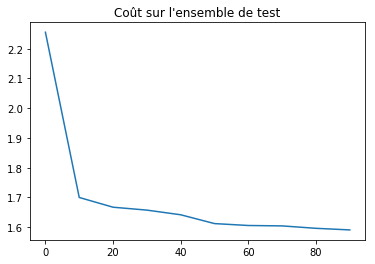

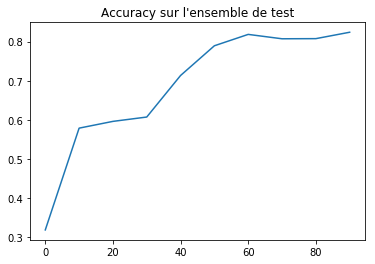

In [22]:
losses = np.array(val_loss)
plt.title("Coût sur l'ensemble de test")
plt.plot(losses[:,0],losses[:,1])
plt.figure()
plt.title("Accuracy sur l'ensemble de test")
plt.plot(losses[:,0], accuracy)

### Comparaison du Adam et SGD

In [8]:
adam_val_loss, adam_accuracy = two_layer_nn(Adam, learning_rate=0.001)
print("ADAM finished")
sgd_val_loss, sgd_accuracy = two_layer_nn(SGD, learning_rate=0.1)
print("SGD finished")

ADAM finished
SGD finished


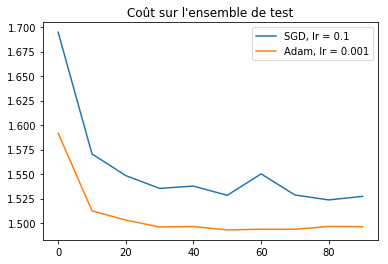

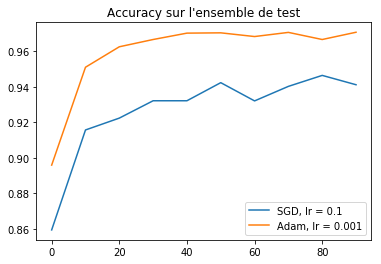

In [9]:
def plot_loss_accuracys(results):
    plt.title("Coût sur l'ensemble de test")
    for (loss, acc) in results:
        loss = np.array(loss)
        plt.plot(loss[:,0],loss[:,1])
    plt.legend()
    plt.figure()
    plt.title("Accuracy sur l'ensemble de test")
    for (loss, acc) in results:
        loss = np.array(loss)
        plt.plot(loss[:,0],loss[:,1])
    plt.plot(loss[:,0], accuracy, lr = 0.1")
    plt.legend()

Adam l'air de performer un peu mieux : il converge plus vite vers mieux accuracy.

## Variation du taille de reseaux

two_layer
[785, 128, 10]
[Linear(in_features=785, out_features=128, bias=True), Relu(), Linear(in_features=128, out_features=10, bias=True), Sigmoid()]
Early stop at epoch 9
three_layer
[785, 128, 64, 10]
[Linear(in_features=785, out_features=128, bias=True), Relu(), Linear(in_features=128, out_features=64, bias=True), Relu(), Linear(in_features=64, out_features=10, bias=True), Sigmoid()]
Early stop at epoch 9
four_layer
[785, 256, 128, 64, 10]
[Linear(in_features=785, out_features=256, bias=True), Relu(), Linear(in_features=256, out_features=128, bias=True), Relu(), Linear(in_features=128, out_features=64, bias=True), Relu(), Linear(in_features=64, out_features=10, bias=True), Sigmoid()]
Early stop at epoch 9
five_layer
[785, 256, 256, 128, 64, 10]
[Linear(in_features=785, out_features=256, bias=True), Relu(), Linear(in_features=256, out_features=256, bias=True), Relu(), Linear(in_features=256, out_features=128, bias=True), Relu(), Linear(in_features=128, out_features=64, bias=True), 

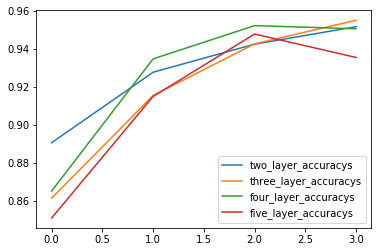

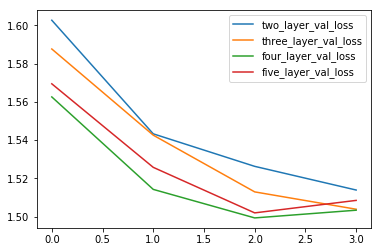

In [61]:
results = {}
dims = [
    ("two_layer", [28*28 + 1, 128, 10]),
    ("three_layer", [28*28 + 1, 128, 64, 10]),
    ("four_layer", [28*28 + 1, 256, 128, 64, 10]),
    ("five_layer", [28*28 + 1, 256, 256, 128, 64, 10])
]
for (name, dim) in dims:
    print(name)
    print(dim)
    val_losses, accuracys = n_layer_nn(Adam, layer_dims=dim, learning_rate=0.001, epochs=100)
    results[name + '_val_loss'] = val_losses
    results[name + '_accuracys'] = accuracys

results_df = pd.DataFrame(results)
acc_cols = [col for col in results_df.columns.tolist() if 'acc' in col]
loss_cols = [col for col in results_df.columns.tolist() if 'loss' in col]
results_df[acc_cols].plot()
results_df[loss_cols].plot()

Nous pouvons voir que il n'y a pas gros différence entre le loss et accuracy de differentes reseaux. Les reseaux de deux et trois couches se performe un peu mieux que les reseaux de quatre et cinq couches. À cause de grand dombre des poids dans les reseaux de 4 et 5 couches, ils commencent de sur-apprendre assez vite.